# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
merged_df = df_offers.merge(df_transactions, how='left', left_on='offer_id', right_on='offer_id')[['offer_id', 'customer_name', 'n']]
merged_df.drop_duplicates(inplace=True)
merge_pivot = pd.pivot_table(merged_df, index='customer_name', values='n', columns='offer_id', dropna=False, fill_value=0)

print(merge_pivot.head())

offer_id       1   2   3   4   5   6   7   8   9   10 ...  23  24  25  26  27  \
customer_name                                         ...                       
Adams           0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   
Allen           0   0   0   0   0   0   0   0   1   0 ...   0   0   0   0   1   
Anderson        0   0   0   0   0   0   0   0   0   0 ...   0   1   0   1   0   
Bailey          0   0   0   0   0   0   1   0   0   0 ...   0   0   0   0   0   
Baker           0   0   0   0   0   0   1   0   0   1 ...   0   0   0   0   0   

offer_id       28  29  30  31  32  
customer_name                      
Adams           0   1   1   0   0  
Allen           0   0   0   0   0  
Anderson        0   0   0   0   0  
Bailey          0   0   1   0   0  
Baker           0   0   0   1   0  

[5 rows x 32 columns]


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

The smaller the SS value the better the clustering. This is becuase smaller SS values represent points that are closer to their respective centroids.

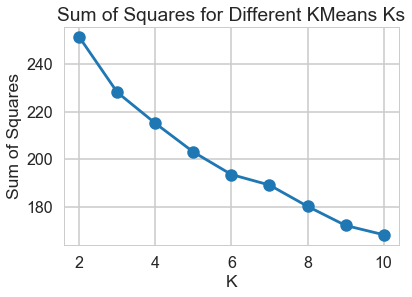

In [5]:
import numpy as np
from sklearn.cluster import KMeans
k_list = np.arange(2,11)

x_cols = merge_pivot.as_matrix()

ss = []
for k in k_list:
    kmeans = KMeans(n_clusters=k, random_state=24)
    kmeans.fit(x_cols)
    ss.append(kmeans.inertia_)
    
_ = plt.plot(k_list, ss, marker='.', markersize=25)
_ = plt.xlabel('K')
_ = plt.ylabel('Sum of Squares')
_ = plt.title('Sum of Squares for Different KMeans Ks')
plt.show()


Based on this plot I will pick a K of 6 as that is where the plot seems to level off slightly.

This is somewhat challenging though as there is no clear elbow in this plot.

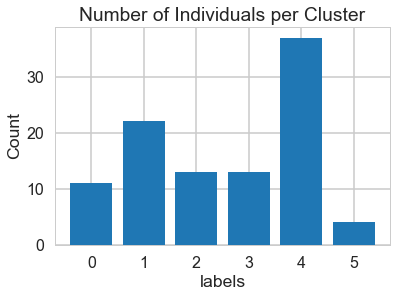

In [12]:
kmeans_6 = KMeans(n_clusters = 6, random_state=24)
kmeans_6.fit(x_cols)
labels_6 = kmeans_6.predict(x_cols)

xs = np.unique(labels_6)
counts = np.bincount(labels_6)

_ = plt.bar(xs, counts, align='center', tick_label=xs)
_ = plt.xlabel('labels')
_ = plt.ylabel('Count')
_ = plt.title('Number of Individuals per Cluster')
plt.show()


### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For k = 2 the average silhouette score is 0.092


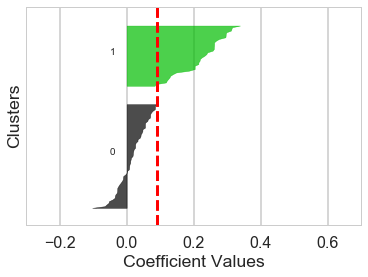

For k = 3 the average silhouette score is 0.113


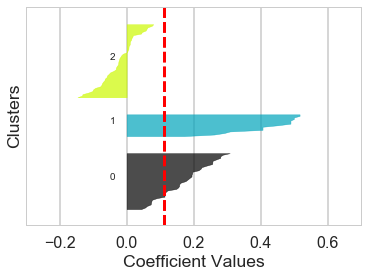

For k = 4 the average silhouette score is 0.125


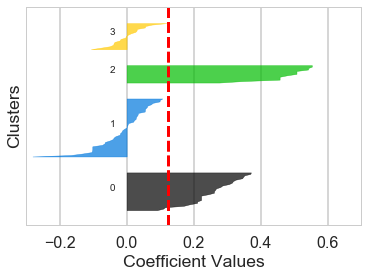

For k = 5 the average silhouette score is 0.127


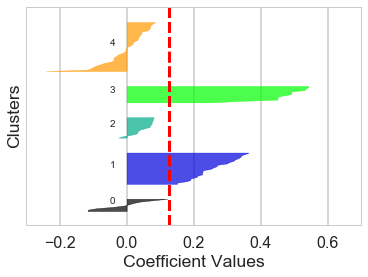

For k = 6 the average silhouette score is 0.129


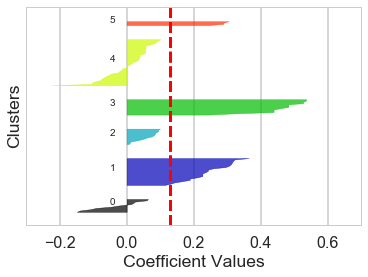

For k = 7 the average silhouette score is 0.107


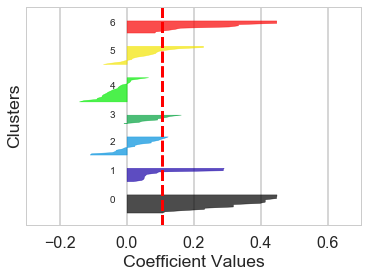

For k = 8 the average silhouette score is 0.109


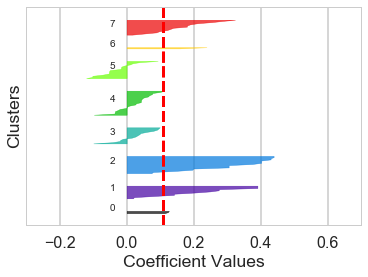

For k = 9 the average silhouette score is 0.117


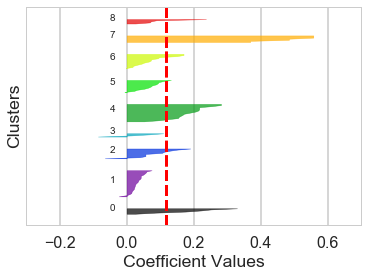

For k = 10 the average silhouette score is 0.123


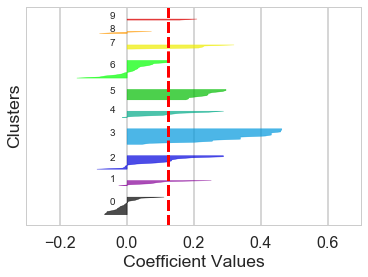

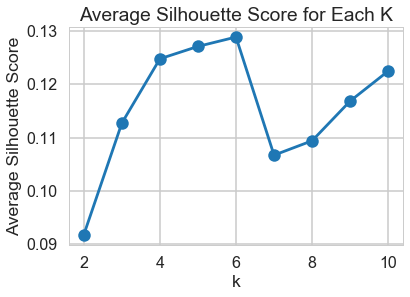


The best silhouette score was 0.129 for k = 6


In [92]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

sil_scores = []
best_kmeans_score = 0.0
for k in k_list:
    fig, (ax1) = plt.subplots(1,1)
    ax1.set_xlim([-0.3, 0.7])
    ax1.set_ylim([0, len(x_cols) + (k+1)*10])
        
    kmeans = KMeans(n_clusters=k, random_state=24)
    labels = kmeans.fit_predict(x_cols)
    
    silhouette_avg = silhouette_score(x_cols, labels)
    
    if silhouette_avg > best_kmeans_score:
        best_kmeans_score = silhouette_avg
        best_k = k
        
    sil_scores.append(silhouette_avg)
    print("For k =", k, 'the average silhouette score is', round(silhouette_avg, 3))
    
    sample_silhouette_values = silhouette_samples(x_cols, labels)

    y_lower = 10
    for i in range(k):
        ith_cluster_sil_values = sample_silhouette_values[labels == i]
        ith_cluster_sil_values.sort()
        
        size_cluster_i = ith_cluster_sil_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.spectral(float(i) / k)

        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_sil_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10
        ax1.set_xlabel("Coefficient Values")
        ax1.set_ylabel("Clusters")
        
        #vertical line as silhouette score
        ax1.axvline(x=silhouette_avg, color='red', linestyle='--')
        
        ax1.set_yticks([])
        ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6])
        
#         #second plot with clusters as scatter plot
#         colors = cm.spectral(labels.astype(float)/k)
#         ax2.scatter()
    
    

    plt.show()
    

_ = plt.plot(k_list, sil_scores, marker = '.', markersize=25)
_ = plt.xlabel('k')
_ = plt.ylabel('Average Silhouette Score')
_ = plt.title('Average Silhouette Score for Each K')
plt.show()

print('')
print('The best silhouette score was', round(best_kmeans_score,3), 'for k =', best_k)

This silhouette score plot indicates that we should choose a k of 6 which is what we chose using the SS approach.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=24)
transformed = pca.fit_transform(x_cols)
xs = transformed[:,0]
ys = transformed[:,1]


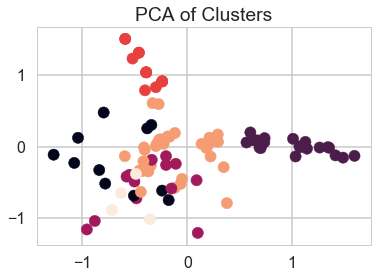

In [32]:
customers = merge_pivot.index.tolist()
customer_pca = pd.DataFrame({'customer':customers, 'cluster':labels_6, 'x':xs, 'y':ys})


_ = plt.scatter(customer_pca['x'], customer_pca['y'], c=customer_pca['cluster'])
_ = plt.title('PCA of Clusters')
plt.show()

There are definitely some distinct clusters but I don't think that our clustering perfectly fit this dataset. By my approximation maybe something like 5 clusters would have been more appropriate. Since both methods came up with the same K they were equally good/bad at picking clusters.

In [35]:
full_merge = df_offers.merge(df_transactions, how='left', left_on='offer_id', right_on='offer_id')

print(full_merge.head())
print(merged_df.head())


   offer_id campaign varietal  min_qty  discount  origin  past_peak  \
0         1  January   Malbec       72        56  France      False   
1         1  January   Malbec       72        56  France      False   
2         1  January   Malbec       72        56  France      False   
3         1  January   Malbec       72        56  France      False   
4         1  January   Malbec       72        56  France      False   

  customer_name  n  
0        Thomas  1  
1       Jackson  1  
2      Mitchell  1  
3      Peterson  1  
4          Wood  1  
   offer_id customer_name  n
0         1        Thomas  1
1         1       Jackson  1
2         1      Mitchell  1
3         1      Peterson  1
4         1          Wood  1


Looking at the offer information it strikes me that the clusters might work better if we focus on specific things. Both the varietals and origin data have nine categories. I wonder if we used nine clusters if we might see some better clusters

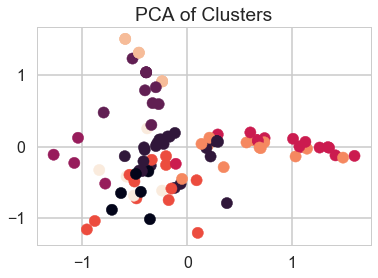

In [37]:
kmeans_9 = KMeans(n_clusters = 9, random_state=24)
kmeans_9.fit(x_cols)
labels_9 = kmeans_9.predict(x_cols)

customer_pca_9 = pd.DataFrame({'customer':customers, 'cluster':labels_9, 'x':xs, 'y':ys})

_ = plt.scatter(customer_pca_9['x'], customer_pca_9['y'], c=customer_pca_9['cluster'])
_ = plt.title('PCA of Clusters')
plt.show()

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

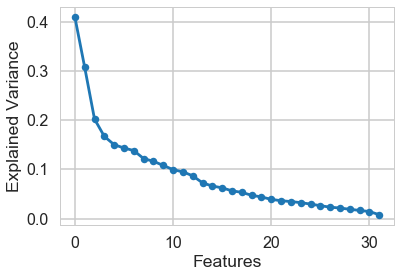

In [46]:
#your turn
# Initialize a new PCA model with a default number of components.
pca = PCA()
pca.fit(x_cols)

features = range(pca.n_components_)

_ = plt.plot(features, pca.explained_variance_, marker='.', markersize=15)
_ = plt.xlabel('Features')
_ = plt.ylabel('Explained Variance')
plt.show()


Based on the above plot, it looks like five is possibly the optimal number of dimensions.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [93]:
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN

algorithms = ['KMeans','AffinityPropagation', 'SpectralClustering', 'AgglomerativeClustering', 'DBSCAN']
algorithm_silscores = pd.Series(index=algorithms)

algorithm_silscores['KMeans'] = best_kmeans_score

### Affinity Propagation

In [94]:
damps = [0.5, 0.6, 0.7, 0.8, 0.9]

best_score = 0.0
for damp in damps:
    ap = AffinityPropagation(damping=damp)
    labels_ap = ap.fit_predict(x_cols)
    sil_avg = silhouette_score(x_cols, labels_ap, random_state=24)

    if sil_avg > best_score:
        best_score = sil_avg
        best_clusters = len(np.unique(labels_ap))
    print('damping = ',damp, 'Clusters = ',len(np.unique(labels_ap)), 'Silhouette Average', sil_avg)

print('\nThe best fit results in ',best_clusters,'clusters and an average silhouette score of',best_score)
algorithm_silscores['AffinityPropagation'] = best_score

damping =  0.5 Clusters =  14 Silhouette Average 0.12346523604478911
damping =  0.6 Clusters =  14 Silhouette Average 0.12346523604478911
damping =  0.7 Clusters =  14 Silhouette Average 0.12346523604478911
damping =  0.8 Clusters =  11 Silhouette Average 0.08954554999885996
damping =  0.9 Clusters =  11 Silhouette Average 0.08954554999885996

The best fit results in  14 clusters and an average silhouette score of 0.12346523604478911


### Spectral Clustering

In [95]:
k_list = np.arange(2,11)

best_score = 0.0
for k in k_list:
    sc = SpectralClustering(n_clusters=k, random_state=24)
    labels_sc = sc.fit_predict(x_cols)
    sil_avg = silhouette_score(x_cols, labels_sc, random_state=24)

    if sil_avg > best_score:
        best_score = sil_avg
        best_clusters = k

    print('Clusters = ',k, 'Silhouette Average', sil_avg)
print('')
print('The best fit came from', best_clusters,'clusters with an average silhouette score of',best_score)
algorithm_silscores['SpectralClustering'] = best_score

Clusters =  2 Silhouette Average 0.0591405970172056
Clusters =  3 Silhouette Average 0.09990591231024579
Clusters =  4 Silhouette Average 0.029065698932750638
Clusters =  5 Silhouette Average 0.02640244377032763
Clusters =  6 Silhouette Average 0.017596416995300394
Clusters =  7 Silhouette Average 0.04791935350456086
Clusters =  8 Silhouette Average 0.053915062183403445
Clusters =  9 Silhouette Average 0.03409778646759826
Clusters =  10 Silhouette Average 0.054124749389208124

The best fit came from 3 clusters with an average silhouette score of 0.09990591231024579


### Agglomerative Clustering

In [96]:
k_list = np.arange(2,11)
linkage_types = ['ward', 'complete', 'average']

best_score = 0.0
for k in k_list:
    for linkage in linkage_types:
        agg_cl = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        labels_agg = agg_cl.fit_predict(x_cols)
        sil_avg = silhouette_score(x_cols, labels_agg, random_state=24)
        
        if sil_avg > best_score:
            best_score = sil_avg
            best_k = k
            best_linkage = linkage
        print('For', k,'clusters and linkage type:', linkage,'the sillhouette average is', sil_avg)

print('')
print('The best fit came from', best_k,'clusters with a linkage type:"'+ best_linkage+'"',\
      'and an average silhouette score of',best_score)
algorithm_silscores['AgglomerativeClustering'] = best_score

For 2 clusters and linkage type: ward the sillhouette average is 0.08258017823184984
For 2 clusters and linkage type: complete the sillhouette average is 0.2348896595208253
For 2 clusters and linkage type: average the sillhouette average is 0.2135580573835938
For 3 clusters and linkage type: ward the sillhouette average is 0.11625878863607858
For 3 clusters and linkage type: complete the sillhouette average is 0.0564209072156317
For 3 clusters and linkage type: average the sillhouette average is 0.18987407904100467
For 4 clusters and linkage type: ward the sillhouette average is 0.128937578158815
For 4 clusters and linkage type: complete the sillhouette average is 0.04965592388360875
For 4 clusters and linkage type: average the sillhouette average is 0.16084385829113018
For 5 clusters and linkage type: ward the sillhouette average is 0.14089739970831974
For 5 clusters and linkage type: complete the sillhouette average is 0.08118536531581164
For 5 clusters and linkage type: average the 

### DBSCAN

In [97]:
min_list = [1,2,3]

best_score = 0.0
for min_size in min_list:
    dbscan = DBSCAN(min_samples=min_size)
    labels_db = dbscan.fit_predict(x_cols)
    sil_avg = silhouette_score(x_cols, labels_db, random_state=24)
    
    if sil_avg > best_score:
        best_score = sil_avg
        best_size = min_size
        
    print('For a minimum neighborhood size of', min_size, 'the average silhouette score is', sil_avg)
    
print('')
print('The best fit came from a minimum neighborhood size of', best_size, 'and produced and average silhoette score of', best_score)
algorithm_silscores['DBSCAN'] = best_score
    

For a minimum neighborhood size of 1 the average silhouette score is 0.19
For a minimum neighborhood size of 2 the average silhouette score is -0.021678059481408066
For a minimum neighborhood size of 3 the average silhouette score is -0.10663555825496372

The best fit came from a minimum neighborhood size of 1 and produced and average silhoette score of 0.19


## Summary

In [98]:
print(algorithm_silscores)

KMeans                     0.128894
AffinityPropagation        0.123465
SpectralClustering         0.099906
AgglomerativeClustering    0.234890
DBSCAN                     0.190000
dtype: float64


Based on this analysis the best clustering of the data came when using Agglomerative Clustering with 2 clusters and complete linkage. This had a higher average silhouette score than our original KMeans clustering. But since all of the clustering applications provided an average silhouette score of less than 0.25 we can infer that none of them found any substantial structure in the data. 

This isn't that surprising in the end. The data are pretty sparse. There are 32 different features and 100 customers and the average number of transactions per customer was just over 3. This means that there isn't a ton of data on these customers yet and trying to cluster them this early in the wine buying process might just be futile. If more data were collected we might start to see some better trends in the future.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html